In [11]:
%matplotlib notebook

import os
from os.path import isfile, join
import numpy as np
from PIL import Image, ImageOps
import cv2
from defisheye import Defisheye
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sympy.geometry import Point, Circle

In [ ]:
def defish():
    for elem in video_list:
        video_path= PATH + elem
        name = elem[0:-4]
        video_output_path = PATH + name + "_defisheyed.mp4"

        xcenter = int(defish_settings[elem][1])+1 #round up
        ycenter = int(defish_settings[elem][2])+1
        radius = int(defish_settings[elem][0])+1
        space = 1000
        
        video = cv2.VideoCapture(video_path)

        defish_frame_array = []
        currentframe = 0
        while(True):
            ret, frame = video.read()

            if ret:
                img_out = f"{PATH}_{name}_{currentframe}.jpg" 
                frame = Image.fromarray(frame)
                frame = ImageOps.expand(frame, border=space, fill=50)
                frame = np.array(frame)
                frame = frame[(ycenter+space-radius):(ycenter+space+radius), (xcenter+space-radius):(xcenter+space+radius)] #crop the image
                
                obj = Defisheye(frame, dtype=defish_dtype, format=defish_format, fov=defish_fov, pfov=defish_pfov, radius=radius, xcenter=radius, ycenter=radius)
                defish_frame = obj.convert(img_out)
                #
                
                width, height, layers = defish_frame.shape
                size = (width, height)
                defish_frame_array.append(defish_frame)

                os.remove(img_out) 
                currentframe += 1
            else:
                break

        out = cv2.VideoWriter(video_output_path, cv2.VideoWriter_fourcc(*"MP4V"), fps, size)
        for i in range(len(defish_frame_array)):
            out.write(defish_frame_array[i])

        out.release()
    
def onclick(event):
    x = event.xdata
    y = event.ydata
    three_points.append([x, y])
    
def update_defish_settings(n, three_points):
        c2 = Circle(Point(three_points[0]), Point(three_points[1]), Point(three_points[2]))
      
        radius = float(c2.radius)
        xcenter = float(c2.center.x)
        ycenter = float(c2.center.y)
        
        defish_settings[video_list[n]] = [radius, xcenter, ycenter]
        
        three_points=[]
        
def show_circle(n):
    video_path = PATH + video_list[n]
    video = cv2.VideoCapture(video_path)

    ret, frame = video.read()
    if ret:
        height, width, layers = frame.shape
        fig, ax = plt.subplots()
        im_extent = 0, width, 0, height
        ax.imshow(frame, extent = im_extent)
        c = patches.Circle((defish_settings[video_list[n]][1], defish_settings[video_list[n]][2]), radius=defish_settings[video_list[n]][0], fill =False, color="green", linewidth=2)
        ax.add_artist(c)
        plt.scatter(defish_settings[video_list[n]][1], defish_settings[video_list[n]][2])
        plt.show()
        
def get_points_for_circle(n):
    video_path = PATH + video_list[n]
    video = cv2.VideoCapture(video_path)

    ret, frame = video.read()
    if ret:
        height, width, layers = frame.shape
        fig, ax = plt.subplots()
        im_extent = 0, width, 0, height
        ax.imshow(frame, extent = im_extent)
        cid = fig.canvas.mpl_connect('button_press_event', onclick)
        three_points=[]
        
        plt.show
        
def initialize_variables():
    global defish_dtype, defish_format, defish_fov, defish_pfov, video_list, three_points, defish_settings
    
    defish_dtype = 'linear'
    defish_format = 'fullframe'
    defish_fov = 180
    defish_pfov = 120
    
    video_list = [files for files in os.listdir(PATH) if files.endswith(".mp4")]
    three_points=[]
    defish_settings = {}

    print(video_list)

Define input variables

In [14]:
PATH = "C:\\Users\\kobel\\Documents\\Medizin\\Doktorarbeit\\Data\\Videos\\"
fps = 40

initialize_variables()

['210_F1-66_220321_OTT.mp4', '211_F1-3_220403_OTR.mp4']


Run the Code for each element in video_list individually.

<IPython.core.display.Javascript object>


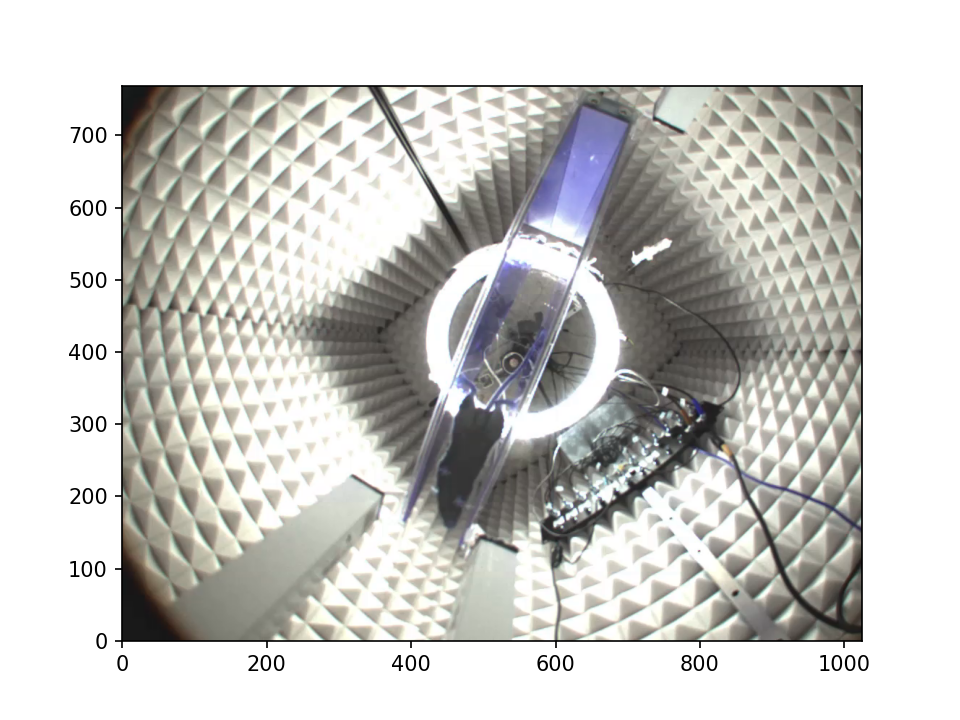

UnboundLocalError: local variable 'three_points' referenced before assignment

In [23]:
n = 0 # = indexing elements in video_list
get_points_for_circle(n)

<IPython.core.display.Javascript object>


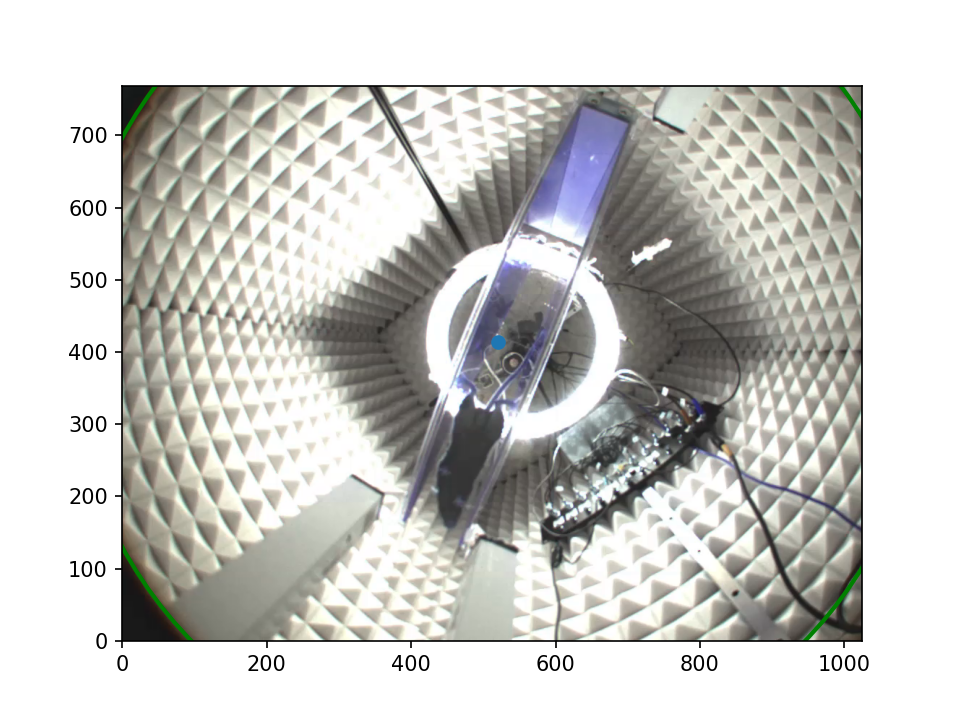

In [19]:
update_defish_settings(n, three_points)
show_circle(n) #just to confirm, that the points are drawn correctly

In [ ]:
defish()